## Preprocessing with `scanpy`

Data Preprocesing and cell filtering with `scanpy` library for Mouse Adult Brain Cell dataset.
Dataset can be found at http://pklab.med.harvard.edu/velocyto/DentateGyrus/DentateGyrus.loom

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22.1 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
adata = sc.read_loom("write/DentateGyrus.loom")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata

AnnData object with n_obs × n_vars = 18213 × 27998 
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [5]:
# remove unnecessary observations
for obs_id in adata.obs.keys():
    if obs_id not in ["Clusters", "ClusterName", "TSNE1", "TSNE2", "Date_Captured"]:
        del adata.obs[obs_id]
        
for var_id in adata.var.keys():
    del adata.var[var_id]

adata.var["genes"] = list(adata.var.index)
adata.obsm["X_tsne"] = np.swapaxes(np.vstack((adata.obs["TSNE1"], adata.obs["TSNE2"])), 0, 1)
del adata.obs["TSNE1"]
del adata.obs["TSNE2"]

In [6]:
adata.var_names_make_unique()

In [7]:
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

... storing 'ClusterName' as categorical
... storing 'Date_Captured' as categorical
... storing 'genes' as categorical


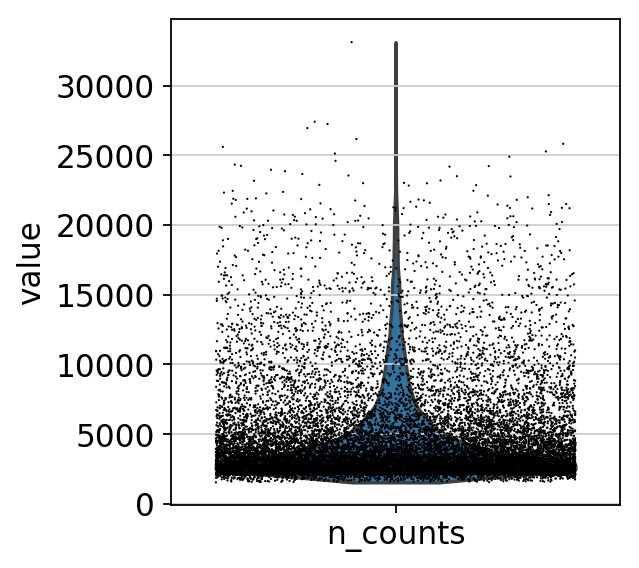

In [8]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

normalizing counts per cell
    finished (0:00:00)


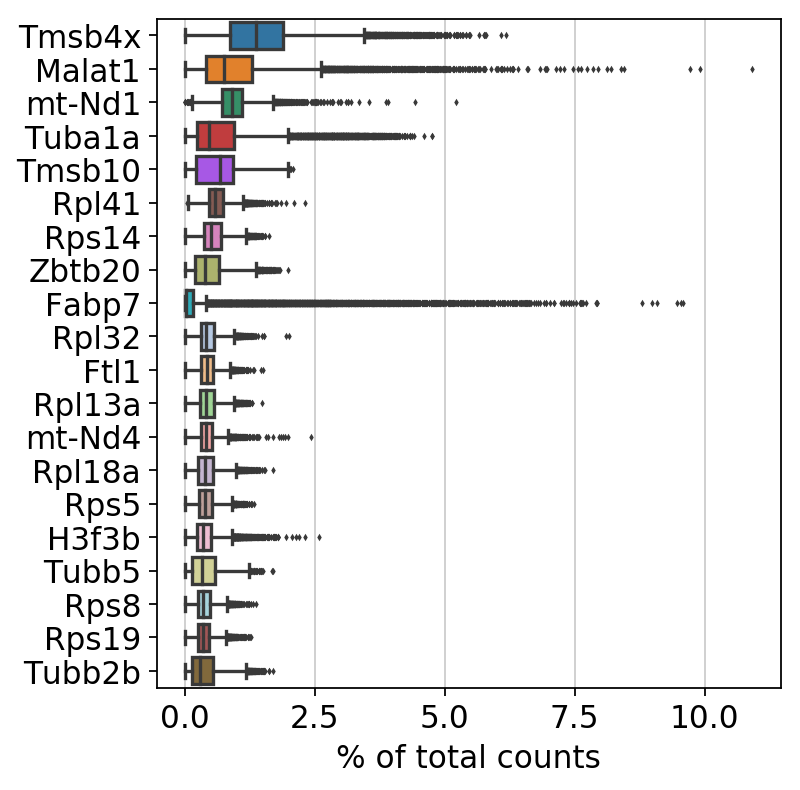

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [10]:
sc.pp.filter_cells(adata, min_genes=2000)

filtered out 11885 cells that have less than 2000 genes expressed


In [11]:
sc.pp.filter_genes(adata, min_cells=200)

filtered out 17670 genes that are detected in less than 200 cells


In [12]:
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

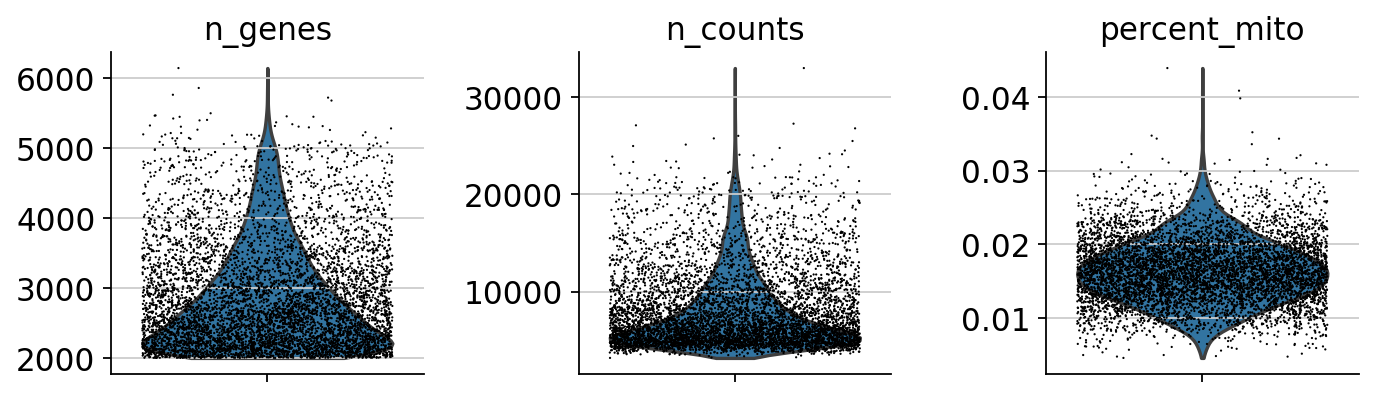

In [13]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

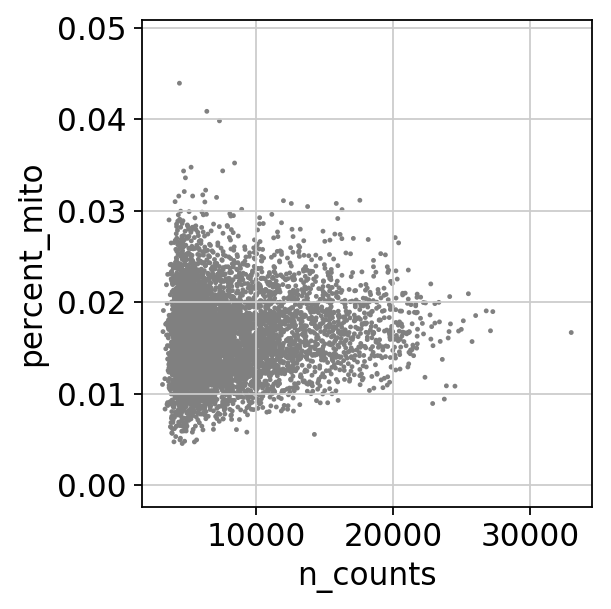

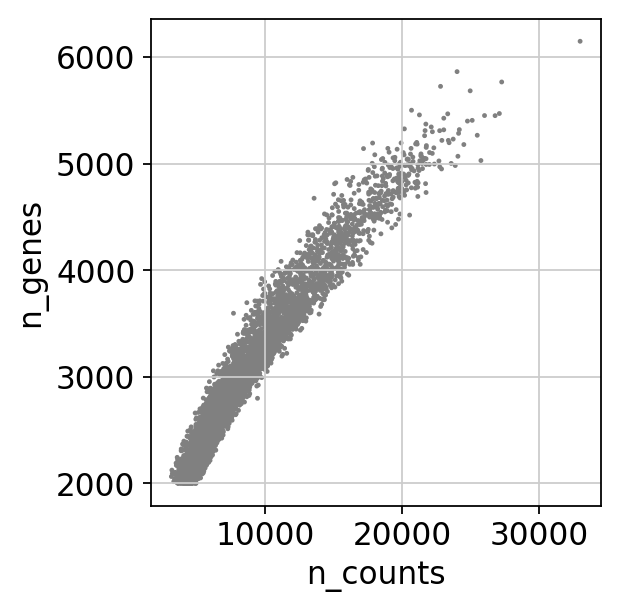

In [14]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [15]:
adata = adata[adata.obs.n_genes < 4500, :]
adata = adata[adata.obs.percent_mito < 0.025, :]

In [16]:
adata

View of AnnData object with n_obs × n_vars = 5827 × 10328 
    obs: 'ClusterName', 'Clusters', 'Date_Captured', 'n_counts', 'n_genes', 'percent_mito'
    var: 'genes', 'n_cells'
    obsm: 'X_tsne'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [17]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [18]:
sc.pp.log1p(adata)

In [19]:
adata.raw = adata

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.0)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


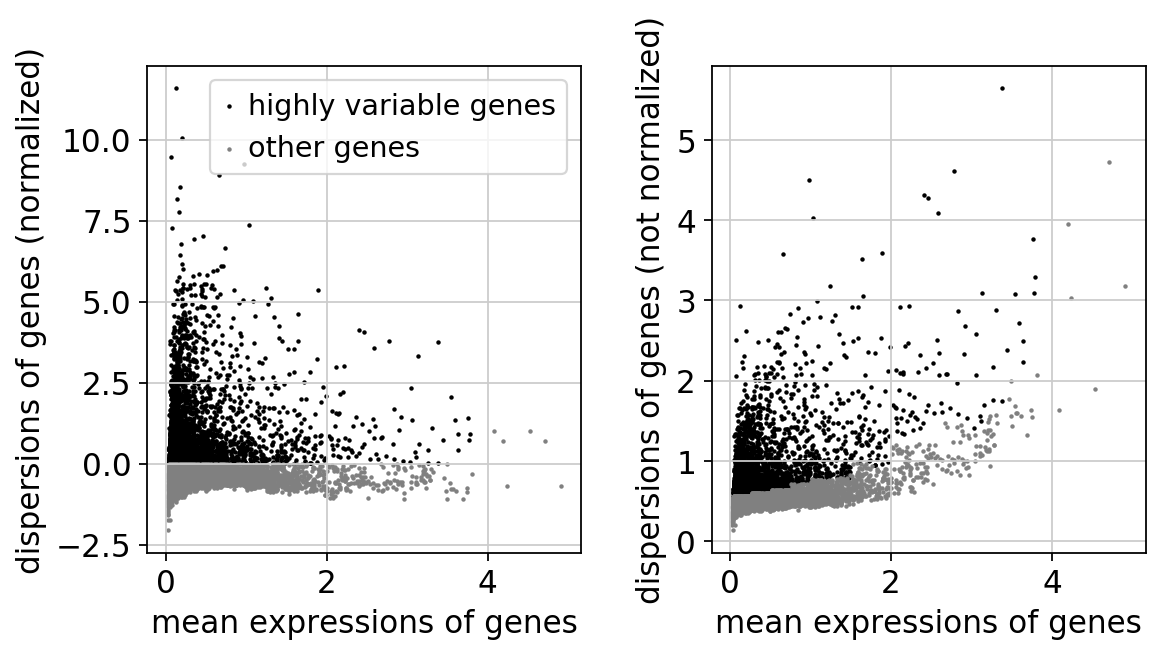

In [21]:
sc.pl.highly_variable_genes(adata)


In [22]:
adata.uns["all_genes"] = adata.var["genes"]
sum(adata.var.highly_variable)

2895

In [23]:
adata = adata[:, adata.var.highly_variable]

In [24]:
adata

View of AnnData object with n_obs × n_vars = 5827 × 2895 
    obs: 'ClusterName', 'Clusters', 'Date_Captured', 'n_counts', 'n_genes', 'percent_mito'
    var: 'genes', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'all_genes'
    obsm: 'X_tsne'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [25]:
# sc.pp.scale(adata, max_value=10)

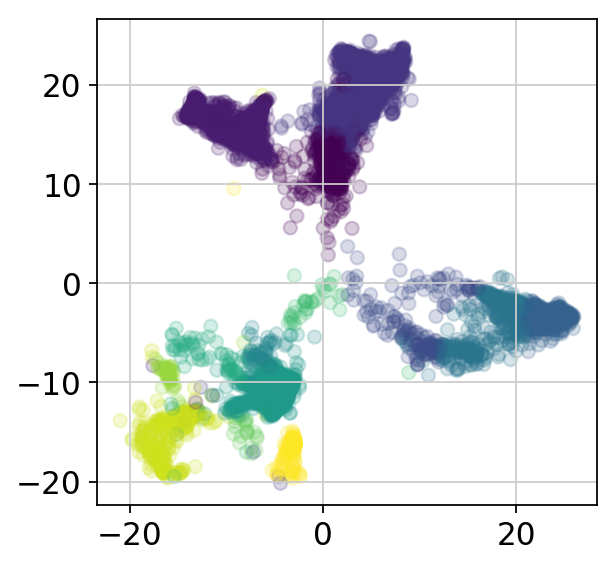

In [33]:
plt.scatter(adata.obsm["X_tsne"][:, 0],adata.obsm["X_tsne"][:, 1], c=adata.obs.Clusters, alpha=0.2)

In [34]:
adata.write("write/DentateGyrus_1.h5ad")

In [4]:
adata.X

<18213x27998 sparse matrix of type '<class 'numpy.float32'>'
	with 35718941 stored elements in Compressed Sparse Row format>